In [1]:
import matplotlib as mpl
%matplotlib inline

from glob import glob
import tensorflow as tf
import os
import nibabel as nb
import numpy as np
from nilearn import image
from nilearn.plotting import plot_glass_brain
from skimage.feature import peak_local_max
import random
import io
import scipy.ndimage

def _get_resize_arg(target_shape):
    mni_shape_mm = np.array([148.0, 184.0, 156.0])
    target_resolution_mm = np.ceil(
        mni_shape_mm / np.array(target_shape)).astype(
        np.int32)
    target_affine = np.array([[4., 0., 0., -75.],
                              [0., 4., 0., -105.],
                              [0., 0., 4., -70.],
                              [0., 0., 0., 1.]])
    target_affine[0, 0] = target_resolution_mm[0]
    target_affine[1, 1] = target_resolution_mm[1]
    target_affine[2, 2] = target_resolution_mm[2]
    return target_affine, list(target_shape)


C:\Users\filo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\filo\Anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [21]:
def count_peaks(path, target_shape, smoothness_level, cluster_forming_thr, cluster_size_thr, min_distance, num_peaks_per_label):
    
    def _get_resize_arg(target_shape):
        mni_shape_mm = np.array([148.0, 184.0, 156.0])
        target_resolution_mm = np.ceil(
            mni_shape_mm / np.array(target_shape)).astype(
            np.int32)
        target_affine = np.array([[4., 0., 0., -75.],
                                  [0., 4., 0., -105.],
                                  [0., 0., 4., -70.],
                                  [0., 0., 0., 1.]])
        target_affine[0, 0] = target_resolution_mm[0]
        target_affine[1, 1] = target_resolution_mm[1]
        target_affine[2, 2] = target_resolution_mm[2]
        return target_affine, list(target_shape)
    
    target_affine, target_shape = _get_resize_arg(target_shape)

    path_str = path
    filename = path_str.split(os.sep)[-1]
    nii = nb.load(path_str)
    data = nii.get_data()
    data[np.isnan(data)] = 0
    nii = nb.Nifti1Image(data, nii.affine)
    nii = image.resample_img(nii,
                             target_affine=target_affine,
                             target_shape=target_shape)
    if smoothness_level:
        nii = image.smooth_img(nii, smoothness_level)
    data = nii.get_data()
    
    # normalization
    m = np.max(np.abs(data))
    if m != np.max(data):
        data = data*-1
    data = data / m
    data = data.astype(np.float32)
    
    new = np.zeros_like(data)
    new[data > cluster_forming_thr] = 1
    if new.sum() > 0:
        labels, n_features = scipy.ndimage.label(new)
        for j in range(1, n_features+1):
            if (labels == j).sum() < cluster_size_thr:
                labels[labels == j] = 0
        peaks = peak_local_max(data, indices=False, min_distance=min_distance,
                               num_peaks_per_label=num_peaks_per_label,
                               labels=labels,
                               threshold_abs=cluster_forming_thr).astype(np.float32)
        return peaks[peaks > 0].sum()
    else:
        return 0

In [30]:
from glob import glob
from joblib import Parallel, delayed
from math import sqrt
peak_counts = Parallel(n_jobs=4)(delayed(count_peaks)(path,
                                                      target_shape=(32,32,32), 
                                                      smoothness_level=0, 
                                                      cluster_forming_thr=0.6, 
                                                      cluster_size_thr=5,
                                                      min_distance=1,
                                                      num_peaks_per_label=45) for path in glob("D:/data/neurovault/neurovault/vetted/train/*.nii.gz"))
    

C:\Users\filo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\filo\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


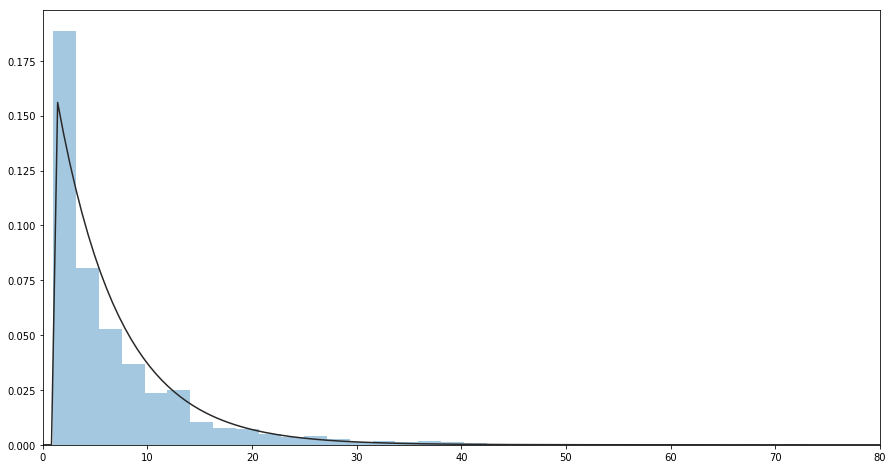

In [31]:
import seaborn as sns
import pylab as plt
from scipy import stats
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot([peak_count for peak_count in peak_counts if peak_count > 0], ax=ax, kde=False, fit=stats.exponnorm, )
ax.set_xlim((0, 80))
fig.show()

In [5]:
len(peak_counts)

14634